# fastai with Astronomy

I am interested in pursuing a PhD in astronomy with a focus on machine learning. While I have experience with machine learning, I know almost nothing about astronomy. To fill the gap, I plan to take up two broad tasks:
- Learn traditional astronomy through courses (like [Crash Course Astronomy](https://thecrashcourse.com/topic/astronomy/)) and reading popular science books (like [Astrophysics for people in a hurry](https://en.wikipedia.org/wiki/Astrophysics_for_People_in_a_Hurry)).
- Take freely available astronomy data and apply ML/DL techniques to answer questions that arise from the data.

This notebook is an adaptation of the first [lesson](https://www.youtube.com/watch?v=8SF_h3xF3cE) of fastai's course [Practical Deep Learning for Coders](https://course.fast.ai). It will detail the results of my experiments with building a classifier for labelling images of galaxies. The data for the same comes from [Galaxy Zoo - The Galaxy Challenge](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge), a competition hosted on Kaggle 8 years ago to "Classify the morphologies of distant galaxies in our Universe". This classifier is built using the fastai [library](https://github.com/fastai/fastai).

In addition, this notebook also contains my thoughts and observations from the first lesson of the course and the first chapter of the book [Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD - Chapter 1](https://colab.research.google.com/github/fastai/fastbook/blob/master/01_intro.ipynb).

## Requirements

If we are running this notebook on Kaggle, the following code snippet will check if our notebook server has internet access. Access to internet is required in order to install packages via `pip` or `conda`. On Google Colab, internet access is enabled by default.

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

# import socket,warnings
# try:
#     socket.setdefaulttimeout(1)
#     socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
# except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In this notebook, we will build a classifier using the `fastai` library. On Google Colab, this library is installed by default. If running this notebook on Kaggle, we can run the following code block to install the library.

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
# import os
# iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# if iskaggle:
#     !pip install -Uqq fastai

As `fastai` is still under active development, it is a good idea to ensure that the version of the package we are using matches the latest available version. This ensures that we will be able to execute commands in the package documentation without any major hiccups. To check the latest available version, we can look at the package's PyPI [page](https://pypi.org/project/fastai/). In the following code blocks, we will check if the installed version is the latest. If not, we install the latest version and verify that the installation was complete.

In [ ]:
# Based on the package's PyPI page.
latest_fastai_version: str = "2.7.9"

In [ ]:
import fastai
current_fastai_version: str = fastai.__version__

In [ ]:
from packaging import version
if version.parse(current_fastai_version) < version.parse(latest_fastai_version):
    del fastai
    !pip install -U fastai
    import fastai
    newly_installed_fastai_version: str = fastai.__version__
    if version.parse(newly_installed_fastai_version) == version.parse(latest_fastai_version):
        print("Congratulations! You now got the latest fastai version.")
else:
    print("You have the latest fastai version installed. That's dope!")

You have the latest fastai version installed. That's dope!


*Customisation*: When running this notebook on Google Colab and in Google Chrome, we can change the font type of the Markdown text as well as code by typing the URL (chrome://settings/fonts) in a tab and modifying the *Standard* and *Fixed-width* font.

## Data

In this notebook, we will build a classifier to label galaxy images provided as part of the Kaggle competition [Galaxy Zoo - The Galaxy Challenge](https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/overview). In order to use this data for classification in Google Colab, we need to perform the following steps:
1. Download the data from the *Data* tab of this page in ZIP format. 
2. Once downloaded, extract the ZIP file to get more ZIP files like `images_training_rev1.zip`, `central_pixel_benchmark.zip`, etc. 
3. Extract all of the ZIP files obtained in step (2) and then delete these ZIP files. 
4. Upload the data to a directory in our Google Drive. In my case, I added it to `Colab Notebooks/fastai_2022/data/galaxy-zoo-the-galaxy-challenge/`.
5. Mount our Google Drive to Colab using the following code snippet. Here, we specify the path to our data and call it `root_dir`.

When executing for the first time or in a while, the following pop-up might be shown:
    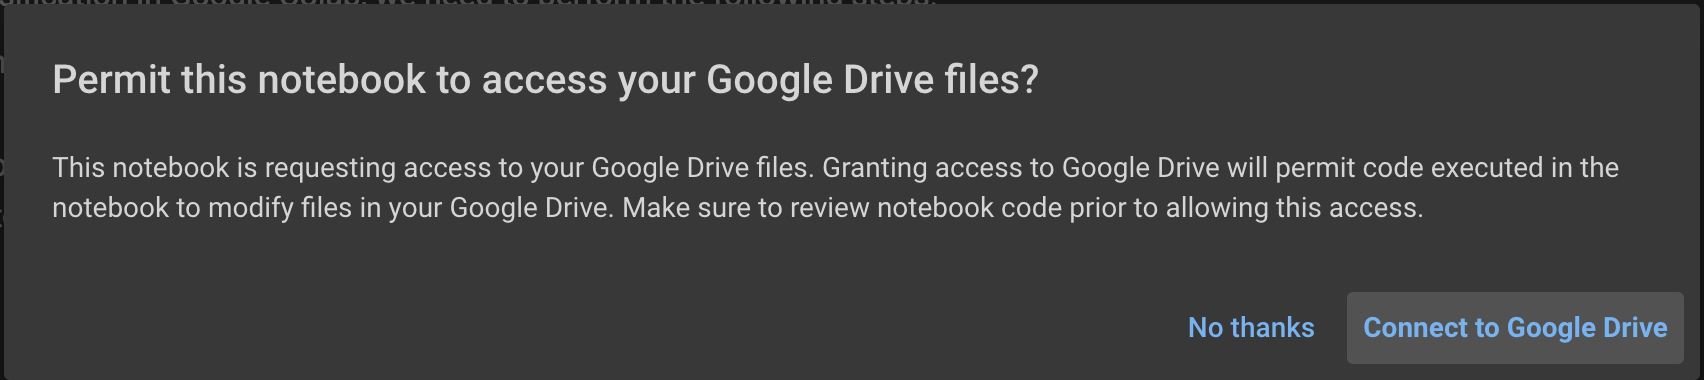

Click on *Connect to Google Drive*, login with your Google account, review the permissions required and click on *Allow*.

In [12]:
from google.colab import files, drive
import sys

drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/fastai_2022/data/galaxy-zoo-the-galaxy-challenge"
sys.path.append(root_dir)

Mounted at /content/gdrive


Let us now do a quick check to ensure that we are able to access the contents of this directory in the notebook.

In [13]:
import os
os.listdir(root_dir)

['images_test_rev1',
 'images_training_rev1',
 'central_pixel_benchmark.csv',
 'all_ones_benchmark.csv',
 'all_zeros_benchmark.csv',
 'training_solutions_rev1.csv']

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

...and then download a URL and take a look at it:

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). 

> It is a construct that is used by PyTorch to iterate through and grab a section of data at a time. 

> `DataBlock` is an intermediate level API that can handle multiple types of ML problems (i.e. inputs and outputs). For the common types, fastai provides specialised APIs (like `SegmentationDataLoaders`) to construct `DataLoaders` with even less code.

> Unlike image data which consists of images and every image is similar in terms of its technical constituents (like RGB colours), each tabular data is defined by the columns (also called *features*) and hence is different. So, when running a fastai learner on tabular data, the method that is called is `fit_one_cycle()` and not `fine_tune()` as is the case for image data.

> Jeremy suggests the following rule of thumb to decide if our problem can be solved effectively with deep learning - if it is a task that a human, even an expert, can do reasonably quickly (like identifying a scene in an image), deep learning will be able to automate the task but if the task requires lots of logical thought process over an extended period of time with not much data (like predicting an election), deep learning won't be a good fit.

In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

> In fastai's parlance, a *learner* is a construct that combines a model and the data used to train the model.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.